In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import itertools

In [2]:
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')
true.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [3]:
true['label'] = 1
fake['label'] = 0

In [4]:
# Combine the sub-datasets in one.
frames = [true.loc[:5000][:], fake.loc[:5000][:]]
df = pd.concat(frames)
df.tail()

,title,text,subject,date,label
4996,Justice Department Announces It Will No Longe...,Republicans are about to lose a huge source of...,News,"August 18, 2016",0
4997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,A pawn working for Donald Trump claimed that w...,News,"August 18, 2016",0
4998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,Fox News is desperate to sabotage Hillary Clin...,News,"August 18, 2016",0
4999,CNN Panelist LAUGHS In Corey Lewandowski’s Fa...,As Donald Trump s campaign continues to sink d...,News,"August 18, 2016",0
5000,Trump Supporter Who Wants To Shoot Black Kids...,"Hi folks, John Harper here, at least if you as...",News,"August 18, 2016",0


In [5]:
X = df.drop('label', axis=1) 
y = df['label']
# Delete missing data
df = df.dropna()
df2 = df.copy()
df2.reset_index(inplace=True)

In [6]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(df2)):
    review = re.sub('[^a-zA-Z]', ' ', df2['text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [7]:
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()
y = df2['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.6f" % score)

accuracy:   0.998001


Confusion matrix, without normalization


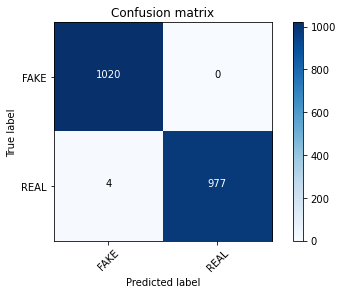

In [10]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [11]:
# Tokenization
review = re.sub('[^a-zA-Z]', ' ', fake['text'][13070])
review = review.lower()
review = review.split() 
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
# Vectorization
val = tfidf_v.transform([review]).toarray()
# Predict 
classifier.predict(val)

array([0], dtype=int64)

In [12]:
pickle.dump(classifier, open('model2.pkl', 'wb'))
pickle.dump(tfidf_v, open('tfidfvect2.pkl', 'wb'))

In [13]:
# Load model and vectorizer
joblib_model = pickle.load(open('model2.pkl', 'rb'))
joblib_vect = pickle.load(open('tfidfvect2.pkl', 'rb'))
val_pkl = joblib_vect.transform([review]).toarray()
joblib_model.predict(val_pkl)

array([0], dtype=int64)